# ECG Image to Time-Series Deep Learning Pipeline
## High-Performance 12-Lead ECG Signal Extraction with SNR Optimization

**Objective**: Develop a complete, high-performance deep learning pipeline to extract 12-lead ECG time-series data from image inputs, optimizing for the modified Signal-to-Noise Ratio (SNR) metric. The pipeline is robust to imaging artifacts and accurately handles scale calibration.

### Key Features:
- Multi-task deep learning with artifact correction
- Automated lead detection and deskewing
- Precise calibration and physical unit conversion
- Optimal resampling to fixed sampling rate (500 Hz)
- SNR-optimized evaluation with cross-correlation alignment
- Robustness to rotation, blur, noise, and grid artifacts

## 1. Import Required Libraries and Dependencies

In [20]:
# Core Libraries
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Computer Vision
import cv2
from scipy import ndimage, interpolate, signal
from scipy.interpolate import CubicSpline, interp1d
from skimage import filters, morphology, measure, transform
from skimage.exposure import equalize_adapthist

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

# Plotting and Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns

# Utilities
from tqdm import tqdm
import json
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Data Loading and Preprocessing Pipeline

In [21]:
class ECGDataLoader:
    """Load and preprocess ECG images and ground truth time-series data"""
    
    def __init__(self, 
                 image_dir: str, 
                 csv_dir: str, 
                 target_size: Tuple[int, int] = (1024, 512),
                 sampling_rate: float = 500.0):
        """
        Args:
            image_dir: Directory containing ECG images
            csv_dir: Directory containing ground truth CSV files
            target_size: Resize images to this size (height, width)
            sampling_rate: Standard sampling rate in Hz
        """
        self.image_dir = Path(image_dir)
        self.csv_dir = Path(csv_dir)
        self.target_size = target_size
        self.sampling_rate = sampling_rate
        
    def load_image(self, image_path: str) -> np.ndarray:
        """Load and normalize ECG image"""
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        # Normalize to [0, 1]
        img = img.astype(np.float32) / 255.0
        
        # Resize to target size
        img = cv2.resize(img, (self.target_size[1], self.target_size[0]))
        
        return img
    
    def load_ground_truth(self, csv_path: str) -> Dict[str, np.ndarray]:
        """Load 12-lead ground truth time series from CSV"""
        df = pd.read_csv(csv_path)
        
        # Assume CSV has columns: time, lead_I, lead_II, ..., lead_aVF
        leads = {}
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        
        for lead_name in lead_names:
            if f'lead_{lead_name}' in df.columns:
                leads[lead_name] = df[f'lead_{lead_name}'].values
        
        time = df['time'].values if 'time' in df.columns else np.arange(len(df)) / self.sampling_rate
        
        return {'time': time, 'leads': leads}
    
    def normalize_image(self, img: np.ndarray) -> np.ndarray:
        """Apply adaptive histogram equalization for contrast enhancement"""
        if img.shape[0] > 0 and img.shape[1] > 0:
            img_eq = equalize_adapthist(img, clip_limit=0.03)
            return img_eq
        return img
    
    def augment_image(self, img: np.ndarray, 
                     rotation_range: float = 5.0,
                     noise_std: float = 0.02) -> np.ndarray:
        """Apply augmentation: rotation and Gaussian noise"""
        # Random rotation
        angle = np.random.uniform(-rotation_range, rotation_range)
        img = transform.rotate(img, angle, preserve_range=True)
        
        # Add Gaussian noise
        noise = np.random.normal(0, noise_std, img.shape)
        img = np.clip(img + noise, 0, 1)
        
        return img
    
    def create_dataset_summary(self) -> Dict:
        """Create a summary of available data"""
        images = list(self.image_dir.glob('*.jpg')) + list(self.image_dir.glob('*.png'))
        csvs = list(self.csv_dir.glob('*.csv'))
        
        summary = {
            'num_images': len(images),
            'num_csvs': len(csvs),
            'image_files': [str(f) for f in images[:5]],  # First 5
            'csv_files': [str(f) for f in csvs[:5]],  # First 5
        }
        return summary

# Example usage
print("ECGDataLoader class defined")

ECGDataLoader class defined


## 3. Image Analysis and Artifact Correction

In [22]:
class GridAndNoiseFilter:
    """Suppress background grid and extract only ECG signal lines"""
    
    def __init__(self, 
                 morphology_kernel_size: int = 3,
                 blur_kernel_size: int = 5):
        self.morphology_kernel_size = morphology_kernel_size
        self.blur_kernel_size = blur_kernel_size
    
    def filter_grid_opencv(self, img: np.ndarray, 
                          threshold: float = 0.3) -> np.ndarray:
        """
        Remove background grid using morphological operations.
        Isolates thin ECG signal lines while suppressing thick grid lines.
        """
        # Convert to 0-255 range for OpenCV
        img_cv = (img * 255).astype(np.uint8)
        
        # Apply adaptive thresholding to separate signal from background
        binary = cv2.adaptiveThreshold(img_cv, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
        
        # Remove small noise components
        kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_small)
        
        # Dilate to connect signal lines
        kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        binary = cv2.dilate(binary, kernel_dilate, iterations=1)
        
        # Extract thin lines (ECG signal) by eroding and checking connectivity
        kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        eroded = cv2.erode(binary, kernel_erode, iterations=1)
        
        # Keep only well-connected components (signal lines)
        num_labels, labels = cv2.connectedComponents(eroded)
        
        signal_mask = np.zeros_like(eroded)
        for label in range(1, num_labels):
            component = (labels == label)
            area = component.sum()
            
            # Keep components with reasonable size (signal lines, not noise or thick grid)
            if 100 < area < 100000:  # Adjust based on image size
                signal_mask |= component.astype(np.uint8)
        
        return signal_mask.astype(np.float32) / 255.0
    
    def filter_grid_morphology(self, img: np.ndarray) -> np.ndarray:
        """
        Use morphological reconstruction to remove grid.
        Preserves thin signal lines while removing thick grid lines.
        """
        # Binary threshold
        binary = img > filters.threshold_otsu(img)
        
        # Morphological opening to remove small noise
        opened = morphology.opening(binary, morphology.disk(1))
        
        # Identify thick structures (grid lines) vs thin structures (signal)
        # Use horizontal and vertical closing to identify grid
        h_kernel = morphology.line(3, angle=0, shape=np.uint8)
        v_kernel = morphology.line(3, angle=90, shape=np.uint8)
        
        h_lines = morphology.closing(opened, h_kernel)
        v_lines = morphology.closing(opened, v_kernel)
        
        grid_estimate = h_lines | v_lines
        
        # Remove grid from original
        signal_only = opened & ~grid_estimate
        
        return signal_only.astype(np.float32)
    
    def denoise_signal(self, img: np.ndarray, 
                      method: str = 'bilateral') -> np.ndarray:
        """Denoise while preserving signal edges"""
        img_cv = (img * 255).astype(np.uint8)
        
        if method == 'bilateral':
            # Bilateral filter preserves edges
            denoised = cv2.bilateralFilter(img_cv, 5, 50, 50)
        elif method == 'median':
            denoised = cv2.medianBlur(img_cv, 5)
        else:
            denoised = img_cv
        
        return denoised.astype(np.float32) / 255.0

print("GridAndNoiseFilter class defined")

GridAndNoiseFilter class defined


## 4. Lead Localization and Deskewing

In [23]:
class LeadLocalizationAndDeskew:
    """Detect lead bounding boxes, calibration marks, and correct image rotation"""
    
    def __init__(self, num_leads: int = 12):
        self.num_leads = num_leads
    
    def estimate_rotation_angle(self, signal_mask: np.ndarray) -> float:
        """
        Estimate image rotation using Hough transform on signal lines.
        Returns rotation angle in degrees.
        """
        # Find edges in signal mask
        edges = cv2.Canny((signal_mask * 255).astype(np.uint8), 50, 150)
        
        # Hough line transform
        lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=50)
        
        if lines is None or len(lines) == 0:
            return 0.0
        
        # Extract angles and find median (robust to outliers)
        angles = []
        for line in lines:
            rho, theta = line[0]
            angle_deg = np.degrees(theta)
            
            # Normalize angle to [-90, 90] range
            if angle_deg > 90:
                angle_deg -= 180
            angles.append(angle_deg)
        
        # Median angle is most robust
        median_angle = np.median(angles)
        
        return median_angle
    
    def deskew_image(self, img: np.ndarray, 
                    rotation_angle: Optional[float] = None) -> Tuple[np.ndarray, float]:
        """
        Deskew image to straighten tilted ECG.
        If rotation_angle not provided, it's estimated from the image.
        """
        # Estimate angle if not provided
        if rotation_angle is None:
            # Simple edge detection and Hough
            edges = cv2.Canny((img * 255).astype(np.uint8), 50, 150)
            rotation_angle = self.estimate_rotation_angle(edges)
        
        # Apply affine transformation
        h, w = img.shape
        center = (w / 2, h / 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
        
        deskewed = cv2.warpAffine(img, rotation_matrix, (w, h),
                                  borderMode=cv2.BORDER_REPLICATE)
        
        return deskewed, rotation_angle
    
    def detect_lead_bboxes(self, signal_mask: np.ndarray,
                          num_leads: int = 12) -> List[Dict]:
        """
        Detect bounding boxes for each lead using connected components.
        Assumes leads are roughly horizontal and arranged vertically.
        """
        # Label connected components
        num_labels, labels = cv2.connectedComponents((signal_mask * 255).astype(np.uint8))
        
        bboxes = []
        for label in range(1, num_labels):
            component = (labels == label)
            y_coords, x_coords = np.where(component)
            
            if len(y_coords) > 0:
                bbox = {
                    'label_id': label,
                    'x_min': int(x_coords.min()),
                    'y_min': int(y_coords.min()),
                    'x_max': int(x_coords.max()),
                    'y_max': int(y_coords.max()),
                    'width': int(x_coords.max() - x_coords.min()),
                    'height': int(y_coords.max() - y_coords.min()),
                    'area': len(y_coords)
                }
                bboxes.append(bbox)
        
        # Sort by y-coordinate (top to bottom)
        bboxes.sort(key=lambda b: b['y_min'])
        
        # Keep top num_leads bboxes by area
        bboxes = sorted(bboxes, key=lambda b: b['area'], reverse=True)[:num_leads]
        bboxes.sort(key=lambda b: b['y_min'])
        
        return bboxes
    
    def detect_calibration_marks(self, img: np.ndarray) -> Dict:
        """
        Detect 1 mV vertical and 0.2 s horizontal calibration marks.
        Typically located at bottom-right corner.
        """
        h, w = img.shape
        
        # Search in bottom-right corner region
        roi_h = h // 4
        roi_w = w // 4
        roi = img[h - roi_h:h, w - roi_w:w]
        
        # Find bright rectangular regions (calibration marks)
        binary = roi > filters.threshold_otsu(roi)
        
        # Label components
        num_labels, labels = cv2.connectedComponents(binary.astype(np.uint8))
        
        calibration_marks = []
        for label in range(1, num_labels):
            component = (labels == label)
            y_coords, x_coords = np.where(component)
            
            if 50 < len(y_coords) < 5000:  # Reasonable size for calibration mark
                mark = {
                    'x_min': x_coords.min() + w - roi_w,
                    'y_min': y_coords.min() + h - roi_h,
                    'x_max': x_coords.max() + w - roi_w,
                    'y_max': y_coords.max() + h - roi_h,
                    'width': x_coords.max() - x_coords.min(),
                    'height': y_coords.max() - y_coords.min(),
                }
                calibration_marks.append(mark)
        
        return {
            'num_marks': len(calibration_marks),
            'marks': calibration_marks
        }

print("LeadLocalizationAndDeskew class defined")

LeadLocalizationAndDeskew class defined


## 5. Signal Trace Extraction and Line Following

In [24]:
class SignalTraceExtractor:
    """Extract pixel coordinates of ECG signal traces using line following"""
    
    def __init__(self, centerline_method: str = 'dynamic_programming'):
        """
        Args:
            centerline_method: 'dynamic_programming', 'a_star', or 'viterbi'
        """
        self.centerline_method = centerline_method
    
    def extract_trace_viterbi(self, signal_mask: np.ndarray, 
                             bbox: Dict) -> np.ndarray:
        """
        Extract signal trace using Viterbi algorithm.
        Models the signal path as a hidden Markov model.
        
        Returns: array of shape (width, 2) with [x, y] pixel coordinates
        """
        x_min, x_max = bbox['x_min'], bbox['x_max']
        y_min, y_max = bbox['y_min'], bbox['y_max']
        
        # Extract ROI
        roi = signal_mask[y_min:y_max+1, x_min:x_max+1]
        roi_h, roi_w = roi.shape
        
        if roi_w < 2:
            return np.array([])
        
        # Initialize probability matrix (log space for numerical stability)
        # Rows: y-position, Cols: x-position
        log_prob = np.full((roi_h, roi_w), -np.inf)
        path_tracker = np.zeros((roi_h, roi_w), dtype=int)
        
        # Emission probabilities from signal mask
        emission = np.log(roi + 1e-6)
        
        # Initialize first column
        log_prob[:, 0] = emission[:, 0]
        
        # Forward pass (Viterbi)
        for x in range(1, roi_w):
            for y in range(roi_h):
                # Consider transitions from previous column (y-1, y, y+1)
                candidates = []
                for prev_y in range(max(0, y-1), min(roi_h, y+2)):
                    candidates.append(log_prob[prev_y, x-1])
                
                max_prob = max(candidates)
                best_prev_y = max(0, y-1) + np.argmax(candidates)
                
                log_prob[y, x] = max_prob + emission[y, x]
                path_tracker[y, x] = best_prev_y
        
        # Backtrack to find best path
        trace = []
        current_y = np.argmax(log_prob[:, -1])
        
        for x in range(roi_w - 1, -1, -1):
            trace.append([x + x_min, current_y + y_min])
            if x > 0:
                current_y = path_tracker[current_y, x]
        
        trace = np.array(trace[::-1])  # Reverse to get left-to-right order
        
        return trace
    
    def extract_trace_dynamic_programming(self, signal_mask: np.ndarray,
                                         bbox: Dict) -> np.ndarray:
        """
        Extract centerline of signal using dynamic programming.
        Minimizes vertical distance traveled while staying on signal.
        """
        x_min, x_max = bbox['x_min'], bbox['x_max']
        y_min, y_max = bbox['y_min'], bbox['y_max']
        
        # Extract ROI
        roi = signal_mask[y_min:y_max+1, x_min:x_max+1]
        roi_h, roi_w = roi.shape
        
        if roi_w < 2:
            return np.array([])
        
        # Cost matrix: prefer staying on signal (low cost where signal is bright)
        cost = 1.0 - roi
        
        # Initialize DP table
        dp = np.full((roi_h, roi_w), np.inf)
        dp[:, 0] = cost[:, 0]
        parent = np.zeros((roi_h, roi_w), dtype=int)
        
        # Forward pass
        for x in range(1, roi_w):
            for y in range(roi_h):
                # Consider transitions: y-1, y, y+1 from previous column
                for prev_y in range(max(0, y-2), min(roi_h, y+3)):
                    transition_cost = dp[prev_y, x-1] + abs(y - prev_y) * 0.5
                    new_cost = transition_cost + cost[y, x]
                    
                    if new_cost < dp[y, x]:
                        dp[y, x] = new_cost
                        parent[y, x] = prev_y
        
        # Backtrack
        trace = []
        current_y = np.argmin(dp[:, -1])
        
        for x in range(roi_w - 1, -1, -1):
            trace.append([x + x_min, current_y + y_min])
            if x > 0:
                current_y = parent[current_y, x]
        
        trace = np.array(trace[::-1])
        
        return trace
    
    def extract_trace_centerline(self, signal_mask: np.ndarray,
                                bbox: Dict) -> np.ndarray:
        """
        Extract centerline by finding the brightest vertical slice at each x.
        Simple but effective for well-defined signals.
        """
        x_min, x_max = bbox['x_min'], bbox['x_max']
        y_min, y_max = bbox['y_min'], bbox['y_max']
        
        # Extract ROI
        roi = signal_mask[y_min:y_max+1, x_min:x_max+1]
        roi_h, roi_w = roi.shape
        
        trace = []
        for x in range(roi_w):
            col = roi[:, x]
            if col.sum() > 0:
                # Center of mass in y
                y_coords = np.arange(roi_h)
                y_center = np.average(y_coords, weights=col)
                trace.append([x + x_min, int(y_center + y_min)])
            else:
                # Interpolate from neighbors
                if len(trace) > 0:
                    trace.append([x + x_min, trace[-1][1]])
        
        return np.array(trace)
    
    def smooth_trace(self, trace: np.ndarray, window_size: int = 5) -> np.ndarray:
        """Apply Savitzky-Golay filter to smooth trace while preserving edges"""
        if len(trace) < window_size:
            return trace
        
        from scipy.signal import savgol_filter
        
        smoothed_x = savgol_filter(trace[:, 0], window_size, 2)
        smoothed_y = savgol_filter(trace[:, 1], window_size, 2)
        
        return np.column_stack([smoothed_x, smoothed_y])

print("SignalTraceExtractor class defined")

SignalTraceExtractor class defined


## 6. Calibration Mark Detection and Scaling

In [25]:
class CalibrationAndScaling:
    """
    Identify calibration marks and convert pixel coordinates to physical units.
    Standard ECG calibration: 1 mV (vertical), 0.2 s (horizontal)
    """
    
    def __init__(self,
                 mv_mark_height: float = 1.0,  # millivolts
                 time_mark_width: float = 0.2):  # seconds
        self.mv_mark_height = mv_mark_height
        self.time_mark_width = time_mark_width
    
    def detect_vertical_calibration(self, img: np.ndarray) -> Optional[float]:
        """
        Detect the vertical 1 mV calibration mark.
        Returns pixel height corresponding to 1 mV.
        """
        h, w = img.shape
        
        # Search in bottom-right corner
        roi_h = h // 5
        roi_w = w // 8
        roi = img[h - roi_h:h, w - roi_w:w]
        
        # Find rectangular bright region
        binary = roi > filters.threshold_otsu(roi)
        
        # Find connected components
        num_labels, labels = cv2.connectedComponents(binary.astype(np.uint8))
        
        for label in range(1, num_labels):
            component = (labels == label)
            y_coords, x_coords = np.where(component)
            
            if len(y_coords) > 20:  # Reasonable size
                mark_height = y_coords.max() - y_coords.min()
                
                # Vertical calibration mark should be taller than wide
                if mark_height > x_coords.max() - x_coords.min():
                    return float(mark_height)
        
        return None
    
    def detect_horizontal_calibration(self, img: np.ndarray) -> Optional[float]:
        """
        Detect the horizontal 0.2 s calibration mark.
        Returns pixel width corresponding to 0.2 s.
        """
        h, w = img.shape
        
        # Search in bottom-right corner
        roi_h = h // 5
        roi_w = w // 8
        roi = img[h - roi_h:h, w - roi_w:w]
        
        # Find rectangular bright region
        binary = roi > filters.threshold_otsu(roi)
        
        # Find connected components
        num_labels, labels = cv2.connectedComponents(binary.astype(np.uint8))
        
        for label in range(1, num_labels):
            component = (labels == label)
            y_coords, x_coords = np.where(component)
            
            if len(x_coords) > 20:  # Reasonable size
                mark_width = x_coords.max() - x_coords.min()
                
                # Horizontal calibration mark should be wider than tall
                if mark_width > y_coords.max() - y_coords.min():
                    return float(mark_width)
        
        return None
    
    def estimate_calibration_factors(self, 
                                     img: np.ndarray,
                                     sampling_rate: float = 500.0) -> Dict:
        """
        Estimate pixel-to-physical conversion factors.
        If calibration marks not found, estimate from image dimensions.
        """
        h, w = img.shape
        
        # Detect calibration marks
        v_calib = self.detect_vertical_calibration(img)
        h_calib = self.detect_horizontal_calibration(img)
        
        # If not detected, estimate from image aspect ratio
        if v_calib is None:
            # Assume typical ECG dimensions
            v_calib = h / 10  # Rough estimate
        
        if h_calib is None:
            # Typical ECG time window: 10 seconds -> 5000 pixels
            estimated_duration = 10.0
            h_calib = w * (self.time_mark_width / estimated_duration)
        
        # Calculate conversion factors
        pixels_per_mv = v_calib / self.mv_mark_height
        pixels_per_second = h_calib / self.time_mark_width
        
        return {
            'pixels_per_mv': pixels_per_mv,
            'pixels_per_second': pixels_per_second,
            'mv_per_pixel': self.mv_mark_height / v_calib,
            'seconds_per_pixel': self.time_mark_width / h_calib,
            'sampling_rate': sampling_rate,
        }
    
    def pixel_to_physical(self, 
                         traces: Dict[str, np.ndarray],
                         calibration: Dict,
                         img_width: int) -> Dict[str, np.ndarray]:
        """
        Convert pixel coordinates to physical units (time, amplitude).
        
        Args:
            traces: Dict with lead names as keys, traces as values (Nx2 arrays)
            calibration: Calibration factors from estimate_calibration_factors
            img_width: Image width in pixels
        
        Returns:
            Dict with lead names as keys, physical traces (Nx2 arrays) as values
        """
        physical_traces = {}
        
        pixels_per_second = calibration['pixels_per_second']
        mv_per_pixel = calibration['mv_per_pixel']
        
        for lead_name, trace in traces.items():
            if len(trace) == 0:
                physical_traces[lead_name] = np.array([])
                continue
            
            # Convert x (pixels) to time (seconds)
            x_pixels = trace[:, 0]
            time = x_pixels / pixels_per_second
            
            # Convert y (pixels) to amplitude (mV)
            y_pixels = trace[:, 1]
            # Invert y-axis (top is negative, bottom is positive in ECG)
            y_pixels_inverted = -y_pixels + np.mean(y_pixels)
            amplitude = y_pixels_inverted * mv_per_pixel
            
            physical_traces[lead_name] = np.column_stack([time, amplitude])
        
        return physical_traces

print("CalibrationAndScaling class defined")

CalibrationAndScaling class defined


## 7. Time-Series Resampling and Interpolation

In [26]:
class TimeSeriesResampler:
    """Resample unevenly spaced time-series to fixed sampling rate using interpolation"""
    
    def __init__(self, target_sampling_rate: float = 500.0):
        """
        Args:
            target_sampling_rate: Target sampling frequency in Hz
        """
        self.target_sampling_rate = target_sampling_rate
    
    def resample_cubic_spline(self,
                             time: np.ndarray,
                             amplitude: np.ndarray) -> np.ndarray:
        """
        Resample using cubic spline interpolation.
        
        Args:
            time: Time points (may be unevenly spaced)
            amplitude: Signal amplitude values
        
        Returns:
            Resampled amplitude values at fixed sampling rate
        """
        if len(time) < 4:  # Need at least 4 points for cubic spline
            return np.array([])
        
        # Create cubic spline
        try:
            spline = CubicSpline(time, amplitude, bc_type='natural')
        except Exception as e:
            print(f"Spline creation failed: {e}, using linear interpolation")
            spline = interp1d(time, amplitude, kind='linear', fill_value='extrapolate')
        
        # Generate new time grid
        t_start = time.min()
        t_end = time.max()
        n_samples = int((t_end - t_start) * self.target_sampling_rate) + 1
        
        new_time = np.linspace(t_start, t_end, n_samples)
        
        # Interpolate
        new_amplitude = spline(new_time)
        
        return new_amplitude
    
    def resample_linear(self,
                       time: np.ndarray,
                       amplitude: np.ndarray) -> np.ndarray:
        """Resample using linear interpolation (faster, less smooth)"""
        if len(time) < 2:
            return np.array([])
        
        interp_func = interp1d(time, amplitude, kind='linear', fill_value='extrapolate')
        
        t_start = time.min()
        t_end = time.max()
        n_samples = int((t_end - t_start) * self.target_sampling_rate) + 1
        
        new_time = np.linspace(t_start, t_end, n_samples)
        new_amplitude = interp_func(new_time)
        
        return new_amplitude
    
    def resample_all_leads(self,
                          physical_traces: Dict[str, np.ndarray],
                          method: str = 'cubic') -> Dict[str, np.ndarray]:
        """
        Resample all leads to fixed sampling rate.
        
        Args:
            physical_traces: Dict with lead names, values are (Nx2) arrays [time, amplitude]
            method: 'cubic' or 'linear'
        
        Returns:
            Dict with lead names, values are resampled amplitudes
        """
        resampled_leads = {}
        
        for lead_name, trace in physical_traces.items():
            if len(trace) < 2:
                resampled_leads[lead_name] = np.array([])
                continue
            
            time = trace[:, 0]
            amplitude = trace[:, 1]
            
            if method == 'cubic':
                resampled = self.resample_cubic_spline(time, amplitude)
            else:
                resampled = self.resample_linear(time, amplitude)
            
            resampled_leads[lead_name] = resampled
        
        return resampled_leads
    
    def validate_resampled_length(self,
                                 resampled_leads: Dict[str, np.ndarray],
                                 target_length: Optional[int] = None) -> bool:
        """
        Validate that all leads have been resampled to the same length.
        If target_length provided, ensure all match that length.
        """
        lengths = [len(v) for v in resampled_leads.values() if len(v) > 0]
        
        if len(set(lengths)) > 1:
            print(f"Warning: Inconsistent resampled lengths: {set(lengths)}")
            return False
        
        if target_length is not None and len(lengths) > 0:
            if lengths[0] != target_length:
                print(f"Warning: Expected length {target_length}, got {lengths[0]}")
                return False
        
        return True

print("TimeSeriesResampler class defined")

TimeSeriesResampler class defined


## 8. Multi-Task Deep Learning Model Architecture

In [27]:
class ECGSegmentationHead(nn.Module):
    """U-Net style decoder for grid/noise filtering segmentation"""
    
    def __init__(self, in_channels: int = 512, out_channels: int = 1):
        super().__init__()
        self.up1 = nn.ConvTranspose2d(in_channels, 256, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.final = nn.Sequential(
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, out_channels, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.up1(x)
        x = self.conv1(x)
        x = self.up2(x)
        x = self.conv2(x)
        x = self.up3(x)
        x = self.final(x)
        return x


class ECGDetectionHead(nn.Module):
    """YOLO-style object detection head for lead and calibration mark detection"""
    
    def __init__(self, in_channels: int = 512, num_leads: int = 12):
        super().__init__()
        self.num_leads = num_leads
        
        # Bounding box regression
        self.bbox_predictor = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_leads * 4)  # 4 coords per lead
        )
        
        # Confidence scores
        self.confidence_predictor = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_leads),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        bboxes = self.bbox_predictor(x)
        confidences = self.confidence_predictor(x)
        
        bboxes = bboxes.view(-1, self.num_leads, 4)
        
        return bboxes, confidences


class ECGRegressionHead(nn.Module):
    """Temporal regression head for signal trace prediction"""
    
    def __init__(self, in_channels: int = 512, sequence_length: int = 1024):
        super().__init__()
        self.sequence_length = sequence_length
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(in_channels, 256, num_layers=2, batch_first=True,
                           bidirectional=True, dropout=0.3)
        
        # Regression layers
        self.regression_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, sequence_length)
        )
    
    def forward(self, x):
        # Reshape for LSTM: (batch, sequence, features)
        batch_size = x.shape[0]
        x = x.view(batch_size, -1, 1)  # Flatten spatial dims
        
        lstm_out, _ = self.lstm(x)
        # Take last output
        lstm_features = lstm_out[:, -1, :]
        
        signal_trace = self.regression_head(lstm_features)
        
        return signal_trace


class MultiTaskECGModel(nn.Module):
    """
    Multi-task deep learning model for ECG image analysis.
    
    Tasks:
    1. Grid/Noise filtering (segmentation)
    2. Lead localization (object detection)
    3. Signal trace extraction (regression)
    """
    
    def __init__(self,
                 backbone: str = 'resnet34',
                 num_leads: int = 12,
                 sequence_length: int = 1024,
                 pretrained: bool = True):
        super().__init__()
        
        self.num_leads = num_leads
        self.sequence_length = sequence_length
        
        # Feature extraction backbone
        if backbone == 'resnet34':
            self.backbone = models.resnet34(pretrained=pretrained)
            backbone_out_channels = 512
        elif backbone == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            backbone_out_channels = 2048
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        # Remove classification head
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        
        # Task heads
        self.segmentation_head = ECGSegmentationHead(backbone_out_channels, out_channels=1)
        self.detection_head = ECGDetectionHead(backbone_out_channels, num_leads=num_leads)
        self.regression_head = ECGRegressionHead(backbone_out_channels, sequence_length=sequence_length)
    
    def forward(self, x):
        """
        Args:
            x: Input image tensor (batch, 1, height, width)
        
        Returns:
            segmentation_mask: (batch, 1, H, W)
            bboxes: (batch, num_leads, 4)
            confidences: (batch, num_leads)
            signal_traces: (batch, sequence_length)
        """
        # Extract features
        features = self.backbone(x)
        
        # Task-specific heads
        segmentation_mask = self.segmentation_head(features)
        bboxes, confidences = self.detection_head(features)
        signal_traces = self.regression_head(features)
        
        return {
            'segmentation': segmentation_mask,
            'bboxes': bboxes,
            'confidences': confidences,
            'signal_traces': signal_traces
        }


# Example instantiation
print("Multi-Task ECG Model classes defined")

# Test model creation (without GPU requirement)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = MultiTaskECGModel(backbone='resnet34', num_leads=12, sequence_length=1024)
print(f"Model created successfully (device: {device})")

Multi-Task ECG Model classes defined
Model created successfully (device: cpu)
Model created successfully (device: cpu)


## 9. Loss Function Definition

In [28]:
class DiceLoss(nn.Module):
    """Dice coefficient loss for segmentation"""
    
    def __init__(self, smooth: float = 1e-6):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        """
        Args:
            predictions: (batch, 1, H, W) with values in [0, 1]
            targets: (batch, 1, H, W) binary targets
        """
        intersection = (predictions * targets).sum()
        union = predictions.sum() + targets.sum()
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        
        return 1.0 - dice


class JaccardLoss(nn.Module):
    """Jaccard (IoU) loss for segmentation"""
    
    def __init__(self, smooth: float = 1e-6):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        """IoU = Intersection / Union"""
        intersection = (predictions * targets).sum()
        union = (predictions + targets - predictions * targets).sum()
        
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        return 1.0 - iou


class MultiTaskECGLoss(nn.Module):
    """Combined loss for multi-task ECG model"""
    
    def __init__(self,
                 w_seg: float = 1.0,
                 w_det: float = 1.0,
                 w_sig: float = 2.0,
                 seg_loss_type: str = 'dice'):
        super().__init__()
        
        self.w_seg = w_seg
        self.w_det = w_det
        self.w_sig = w_sig
        
        # Segmentation loss
        if seg_loss_type == 'dice':
            self.seg_loss = DiceLoss()
        else:
            self.seg_loss = JaccardLoss()
        
        # Detection losses
        self.bbox_loss = nn.SmoothL1Loss()  # IoU-based or L1 for bbox regression
        self.confidence_loss = nn.BCELoss()  # Binary cross-entropy for confidence
        
        # Signal regression loss
        self.signal_loss = nn.MSELoss()
    
    def forward(self, predictions, targets):
        """
        Args:
            predictions: Dict with keys 'segmentation', 'bboxes', 'confidences', 'signal_traces'
            targets: Dict with same keys containing ground truth
        
        Returns:
            Total loss and breakdown of components
        """
        loss_dict = {}
        total_loss = 0.0
        
        # Segmentation loss
        if 'segmentation' in predictions and 'segmentation' in targets:
            seg_loss = self.seg_loss(predictions['segmentation'], targets['segmentation'])
            loss_dict['seg_loss'] = seg_loss.item()
            total_loss += self.w_seg * seg_loss
        
        # Detection losses (bbox + confidence)
        if 'bboxes' in predictions and 'bboxes' in targets:
            bbox_loss = self.bbox_loss(predictions['bboxes'], targets['bboxes'])
            loss_dict['bbox_loss'] = bbox_loss.item()
            total_loss += self.w_det * bbox_loss
        
        if 'confidences' in predictions and 'confidences' in targets:
            conf_loss = self.confidence_loss(predictions['confidences'], targets['confidences'])
            loss_dict['conf_loss'] = conf_loss.item()
            total_loss += self.w_det * conf_loss
        
        # Signal regression loss
        if 'signal_traces' in predictions and 'signal_traces' in targets:
            sig_loss = self.signal_loss(predictions['signal_traces'], targets['signal_traces'])
            loss_dict['sig_loss'] = sig_loss.item()
            total_loss += self.w_sig * sig_loss
        
        loss_dict['total_loss'] = total_loss.item()
        
        return total_loss, loss_dict


print("Loss functions defined")

Loss functions defined


## 10. Training Loop Implementation

In [29]:
class ECGTrainer:
    """Training and evaluation loop for multi-task ECG model"""
    
    def __init__(self,
                 model: nn.Module,
                 device: torch.device,
                 learning_rate: float = 1e-4,
                 weight_decay: float = 1e-5):
        self.model = model.to(device)
        self.device = device
        
        # Optimizer
        self.optimizer = optim.Adam(model.parameters(),
                                   lr=learning_rate,
                                   weight_decay=weight_decay)
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=3,
            verbose=True
        )
        
        # Loss function
        self.criterion = MultiTaskECGLoss(w_seg=1.0, w_det=1.0, w_sig=2.0)
        
        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_seg_loss': [],
            'train_bbox_loss': [],
            'train_sig_loss': []
        }
    
    def train_epoch(self, train_loader: DataLoader) -> Dict:
        """Train for one epoch"""
        self.model.train()
        
        epoch_loss = 0.0
        loss_breakdown = {
            'seg_loss': 0.0,
            'bbox_loss': 0.0,
            'conf_loss': 0.0,
            'sig_loss': 0.0
        }
        
        pbar = tqdm(train_loader, desc='Training', leave=False)
        
        for batch_idx, batch in enumerate(pbar):
            images = batch['image'].to(self.device)
            targets = {
                'segmentation': batch.get('segmentation_mask', None),
                'bboxes': batch.get('bboxes', None),
                'confidences': batch.get('confidences', None),
                'signal_traces': batch.get('signal_traces', None)
            }
            
            # Move targets to device if they exist
            targets = {k: v.to(self.device) if v is not None else None
                      for k, v in targets.items()}
            
            # Forward pass
            self.optimizer.zero_grad()
            predictions = self.model(images)
            
            # Compute loss
            loss, loss_dict = self.criterion(predictions, targets)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            # Accumulate losses
            epoch_loss += loss.item()
            for key in loss_breakdown:
                if key in loss_dict:
                    loss_breakdown[key] += loss_dict[key]
            
            pbar.set_postfix({'loss': loss.item()})
        
        # Average losses
        n_batches = len(train_loader)
        epoch_loss /= n_batches
        for key in loss_breakdown:
            loss_breakdown[key] /= n_batches
        
        return epoch_loss, loss_breakdown
    
    def validate(self, val_loader: DataLoader) -> float:
        """Validate model"""
        self.model.eval()
        
        val_loss = 0.0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc='Validation', leave=False)
            
            for batch in pbar:
                images = batch['image'].to(self.device)
                targets = {
                    'segmentation': batch.get('segmentation_mask', None),
                    'bboxes': batch.get('bboxes', None),
                    'confidences': batch.get('confidences', None),
                    'signal_traces': batch.get('signal_traces', None)
                }
                
                targets = {k: v.to(self.device) if v is not None else None
                          for k, v in targets.items()}
                
                predictions = self.model(images)
                loss, _ = self.criterion(predictions, targets)
                
                val_loss += loss.item()
                pbar.set_postfix({'val_loss': loss.item()})
        
        val_loss /= len(val_loader)
        
        return val_loss
    
    def fit(self,
            train_loader: DataLoader,
            val_loader: Optional[DataLoader] = None,
            epochs: int = 10):
        """
        Train model for specified number of epochs.
        """
        print(f"Starting training for {epochs} epochs...")
        print(f"Device: {self.device}")
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            
            # Train
            train_loss, loss_breakdown = self.train_epoch(train_loader)
            self.history['train_loss'].append(train_loss)
            
            for key in loss_breakdown:
                if key in self.history:
                    self.history[key].append(loss_breakdown[key])
            
            print(f"Train Loss: {train_loss:.6f}")
            print(f"  Seg Loss: {loss_breakdown.get('seg_loss', 0):.6f}")
            print(f"  BBox Loss: {loss_breakdown.get('bbox_loss', 0):.6f}")
            print(f"  Signal Loss: {loss_breakdown.get('sig_loss', 0):.6f}")
            
            # Validate
            if val_loader is not None:
                val_loss = self.validate(val_loader)
                self.history['val_loss'].append(val_loss)
                print(f"Val Loss: {val_loss:.6f}")
                
                # LR scheduling
                self.scheduler.step(val_loss)
        
        print("Training completed!")
        
        return self.history
    
    def save_checkpoint(self, save_path: str):
        """Save model checkpoint"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history
        }
        torch.save(checkpoint, save_path)
        print(f"Checkpoint saved to {save_path}")
    
    def load_checkpoint(self, load_path: str):
        """Load model checkpoint"""
        checkpoint = torch.load(load_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint.get('history', self.history)
        print(f"Checkpoint loaded from {load_path}")


print("ECGTrainer class defined")

ECGTrainer class defined


## 11. SNR Metric Calculation and Evaluation

In [30]:
class SNRMetric:
    """
    Calculate modified Signal-to-Noise Ratio (SNR) metric for ECG evaluation.
    
    The SNR metric compares predicted ECG signals to ground truth with:
    - Optimal time shift alignment (up to 0.2 s)
    - Vertical shift removal
    - Per-lead calculation
    """
    
    def __init__(self, sampling_rate: float = 500.0, max_time_shift: float = 0.2):
        self.sampling_rate = sampling_rate
        self.max_time_shift = max_time_shift
        self.max_lag = int(max_time_shift * sampling_rate)
    
    def find_optimal_time_shift(self,
                               predicted: np.ndarray,
                               ground_truth: np.ndarray) -> Tuple[float, int]:
        """
        Find optimal time shift using cross-correlation.
        
        Args:
            predicted: Predicted signal (1D array)
            ground_truth: Ground truth signal (1D array)
        
        Returns:
            optimal_lag: Optimal lag in samples
            correlation: Maximum correlation value
        """
        if len(predicted) < 2 or len(ground_truth) < 2:
            return 0, 0.0
        
        # Pad to same length if necessary
        max_len = max(len(predicted), len(ground_truth))
        pred_padded = np.pad(predicted, (0, max_len - len(predicted)), mode='constant')
        gt_padded = np.pad(ground_truth, (0, max_len - len(ground_truth)), mode='constant')
        
        # Cross-correlation
        cross_corr = signal.correlate(pred_padded, gt_padded, mode='same')
        
        # Find peak within allowed lag range
        center = len(cross_corr) // 2
        search_start = max(0, center - self.max_lag)
        search_end = min(len(cross_corr), center + self.max_lag)
        
        lag_idx = search_start + np.argmax(cross_corr[search_start:search_end])
        optimal_lag = lag_idx - center
        max_corr = cross_corr[lag_idx]
        
        return optimal_lag, max_corr
    
    def align_signals(self,
                     predicted: np.ndarray,
                     ground_truth: np.ndarray,
                     lag: int = 0) -> Tuple[np.ndarray, np.ndarray]:
        """
        Align signals using time shift and remove vertical offset.
        
        Args:
            predicted: Predicted signal
            ground_truth: Ground truth signal
            lag: Time shift in samples
        
        Returns:
            aligned_pred, aligned_gt: Aligned signals
        """
        # Apply time shift
        if lag > 0:
            aligned_pred = np.roll(predicted, lag)
        elif lag < 0:
            aligned_pred = np.roll(predicted, lag)
        else:
            aligned_pred = predicted.copy()
        
        # Trim to common length
        min_len = min(len(aligned_pred), len(ground_truth))
        aligned_pred = aligned_pred[:min_len]
        aligned_gt = ground_truth[:min_len]
        
        # Remove vertical shift (DC offset)
        vertical_shift = np.mean(aligned_pred) - np.mean(aligned_gt)
        aligned_pred = aligned_pred - vertical_shift
        
        return aligned_pred, aligned_gt
    
    def calculate_snr(self,
                     predicted: np.ndarray,
                     ground_truth: np.ndarray,
                     find_shift: bool = True) -> float:
        """
        Calculate modified SNR (dB) between predicted and ground truth.
        
        SNR (dB) = 10 * log10(P_signal / P_noise)
               = 10 * log10(P_truth / P_error)
        
        Args:
            predicted: Predicted signal
            ground_truth: Ground truth signal
            find_shift: Whether to find optimal time shift
        
        Returns:
            snr_db: SNR in dB (higher is better)
        """
        if len(predicted) == 0 or len(ground_truth) == 0:
            return -np.inf
        
        # Find optimal alignment if enabled
        if find_shift:
            optimal_lag, _ = self.find_optimal_time_shift(predicted, ground_truth)
        else:
            optimal_lag = 0
        
        # Align signals
        aligned_pred, aligned_gt = self.align_signals(predicted, ground_truth, optimal_lag)
        
        if len(aligned_gt) == 0:
            return -np.inf
        
        # Calculate power
        signal_power = np.mean(aligned_gt ** 2)  # Power of ground truth
        error = aligned_pred - aligned_gt
        noise_power = np.mean(error ** 2)
        
        # Avoid division by zero
        if noise_power < 1e-10:
            snr_db = np.inf if signal_power > 1e-10 else 0.0
        else:
            snr_db = 10.0 * np.log10(signal_power / noise_power)
        
        return snr_db
    
    def calculate_multipart_snr(self,
                               predicted_leads: Dict[str, np.ndarray],
                               ground_truth_leads: Dict[str, np.ndarray]) -> Dict:
        """
        Calculate SNR for all 12 leads and aggregate statistics.
        
        Args:
            predicted_leads: Dict with lead names, signal arrays
            ground_truth_leads: Dict with lead names, signal arrays
        
        Returns:
            Dict with per-lead SNR, mean SNR, min SNR, etc.
        """
        snr_per_lead = {}
        valid_snrs = []
        
        for lead_name in ground_truth_leads.keys():
            if lead_name in predicted_leads:
                pred = predicted_leads[lead_name]
                truth = ground_truth_leads[lead_name]
                
                if len(pred) > 0 and len(truth) > 0:
                    snr = self.calculate_snr(pred, truth, find_shift=True)
                    snr_per_lead[lead_name] = snr
                    
                    if np.isfinite(snr):
                        valid_snrs.append(snr)
                else:
                    snr_per_lead[lead_name] = -np.inf
        
        # Aggregate statistics
        results = {
            'per_lead': snr_per_lead,
            'mean_snr': np.mean(valid_snrs) if valid_snrs else -np.inf,
            'median_snr': np.median(valid_snrs) if valid_snrs else -np.inf,
            'min_snr': np.min(valid_snrs) if valid_snrs else -np.inf,
            'max_snr': np.max(valid_snrs) if valid_snrs else -np.inf,
            'std_snr': np.std(valid_snrs) if valid_snrs else 0.0,
            'num_valid_leads': len(valid_snrs)
        }
        
        return results
    
    def print_snr_report(self, snr_results: Dict):
        """Pretty print SNR evaluation report"""
        print("\n" + "="*60)
        print("SNR EVALUATION REPORT")
        print("="*60)
        print(f"Mean SNR (12 leads): {snr_results['mean_snr']:.2f} dB")
        print(f"Median SNR: {snr_results['median_snr']:.2f} dB")
        print(f"Min SNR: {snr_results['min_snr']:.2f} dB")
        print(f"Max SNR: {snr_results['max_snr']:.2f} dB")
        print(f"Std Dev: {snr_results['std_snr']:.2f} dB")
        print(f"Valid Leads: {snr_results['num_valid_leads']}/12")
        print("\nPer-Lead SNR (dB):")
        print("-" * 60)
        for lead_name, snr_val in sorted(snr_results['per_lead'].items()):
            status = "✓" if np.isfinite(snr_val) else "✗"
            print(f"  Lead {lead_name:4s}: {snr_val:8.2f} {status}")
        print("="*60 + "\n")


print("SNRMetric class defined")

SNRMetric class defined


## 12. Model Inference and Pipeline Integration

In [31]:
class ECGInferencePipeline:
    """
    End-to-end inference pipeline integrating all phases:
    1. Image preprocessing and artifact correction
    2. Lead detection and deskewing
    3. Signal trace extraction
    4. Calibration and physical unit conversion
    5. Resampling to fixed sampling rate
    """
    
    def __init__(self,
                 model: nn.Module,
                 device: torch.device,
                 sampling_rate: float = 500.0):
        self.model = model.eval()
        self.device = device
        self.sampling_rate = sampling_rate
        
        # Initialize components
        self.data_loader = ECGDataLoader(image_dir='', csv_dir='', 
                                        target_size=(512, 1024),
                                        sampling_rate=sampling_rate)
        self.grid_filter = GridAndNoiseFilter()
        self.lead_localizer = LeadLocalizationAndDeskew()
        self.trace_extractor = SignalTraceExtractor(centerline_method='dynamic_programming')
        self.calibrator = CalibrationAndScaling()
        self.resampler = TimeSeriesResampler(target_sampling_rate=sampling_rate)
        self.snr_calculator = SNRMetric(sampling_rate=sampling_rate)
    
    def process_single_image(self, image_path: str) -> Dict:
        """
        Process a single ECG image through the complete pipeline.
        
        Args:
            image_path: Path to ECG image (JPEG/PNG)
        
        Returns:
            Dict with extracted signals and metadata
        """
        # Load and preprocess image
        image = self.data_loader.load_image(image_path)
        image_normalized = self.data_loader.normalize_image(image)
        
        # Artifact correction - filter grid and noise
        signal_mask = self.grid_filter.filter_grid_opencv(image_normalized)
        
        # Deskew image
        deskewed_image, rotation_angle = self.lead_localizer.deskew_image(
            image_normalized, rotation_angle=None
        )
        
        # Re-extract signal mask from deskewed image
        signal_mask = self.grid_filter.filter_grid_opencv(deskewed_image)
        
        # Detect lead bounding boxes
        lead_bboxes = self.lead_localizer.detect_lead_bboxes(signal_mask, num_leads=12)
        
        # Detect calibration marks
        calib_info = self.lead_localizer.detect_calibration_marks(deskewed_image)
        
        # Estimate calibration factors
        calibration = self.calibrator.estimate_calibration_factors(deskewed_image, 
                                                                   self.sampling_rate)
        
        # Extract traces for each lead
        traces = {}
        for i, bbox in enumerate(lead_bboxes):
            trace = self.trace_extractor.extract_trace_dynamic_programming(
                signal_mask, bbox
            )
            
            if len(trace) > 0:
                trace = self.trace_extractor.smooth_trace(trace)
                traces[f'Lead_{i}'] = trace
        
        # Convert to physical units
        physical_traces = self.calibrator.pixel_to_physical(traces, calibration,
                                                            deskewed_image.shape[1])
        
        # Resample to fixed sampling rate
        resampled_leads = self.resampler.resample_all_leads(physical_traces, method='cubic')
        
        return {
            'image_path': image_path,
            'rotation_angle': rotation_angle,
            'calibration': calibration,
            'num_leads_detected': len(lead_bboxes),
            'lead_bboxes': lead_bboxes,
            'calibration_marks': calib_info,
            'pixel_traces': traces,
            'physical_traces': physical_traces,
            'resampled_signals': resampled_leads,
            'signal_mask': signal_mask,
            'deskewed_image': deskewed_image
        }
    
    def process_batch(self, image_paths: List[str]) -> List[Dict]:
        """
        Process a batch of ECG images.
        
        Args:
            image_paths: List of paths to ECG images
        
        Returns:
            List of result dicts
        """
        results = []
        
        pbar = tqdm(image_paths, desc='Processing ECG images')
        for img_path in pbar:
            try:
                result = self.process_single_image(img_path)
                results.append(result)
                pbar.set_postfix({'leads': result['num_leads_detected']})
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                results.append({
                    'image_path': img_path,
                    'error': str(e)
                })
        
        return results
    
    def evaluate_with_ground_truth(self,
                                   image_paths: List[str],
                                   ground_truth_csvs: List[str]) -> Dict:
        """
        Process images and evaluate SNR against ground truth.
        
        Args:
            image_paths: List of ECG image paths
            ground_truth_csvs: List of ground truth CSV paths
        
        Returns:
            Dict with SNR statistics and per-sample results
        """
        all_snrs = []
        sample_results = []
        
        for img_path, csv_path in zip(image_paths, ground_truth_csvs):
            # Process image
            try:
                result = self.process_single_image(img_path)
                
                # Load ground truth
                gt_data = self.data_loader.load_ground_truth(csv_path)
                
                # Ensure same format
                gt_leads = {}
                for lead_name, values in gt_data['leads'].items():
                    if len(values) > 0:
                        gt_leads[f'Lead_{lead_name}'] = values
                
                # Calculate SNR
                snr_result = self.snr_calculator.calculate_multipart_snr(
                    result['resampled_signals'],
                    gt_leads
                )
                
                all_snrs.append(snr_result['mean_snr'])
                sample_results.append({
                    'image': img_path,
                    'snr_result': snr_result
                })
            
            except Exception as e:
                print(f"Error evaluating {img_path}: {e}")
        
        # Aggregate statistics
        aggregated = {
            'num_samples': len(sample_results),
            'mean_snr_overall': np.mean(all_snrs) if all_snrs else -np.inf,
            'std_snr_overall': np.std(all_snrs) if all_snrs else 0.0,
            'sample_results': sample_results
        }
        
        return aggregated


print("ECGInferencePipeline class defined")

ECGInferencePipeline class defined


## 13. Robustness Testing on Artifacts

In [32]:
class ArtifactRobustnessTest:
    """
    Test pipeline robustness to common imaging artifacts:
    - Rotation
    - Blur
    - Noise
    - Grid distortions
    - Compression artifacts
    """
    
    def __init__(self, pipeline: ECGInferencePipeline):
        self.pipeline = pipeline
        self.test_results = {}
    
    def apply_rotation(self, image: np.ndarray, angle: float) -> np.ndarray:
        """Apply rotation to image"""
        h, w = image.shape
        center = (w / 2, h / 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h),
                                borderMode=cv2.BORDER_REPLICATE)
        return rotated
    
    def apply_blur(self, image: np.ndarray, kernel_size: int = 5) -> np.ndarray:
        """Apply Gaussian blur"""
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 1.0)
    
    def apply_noise(self, image: np.ndarray, std: float = 0.05) -> np.ndarray:
        """Add Gaussian noise"""
        noise = np.random.normal(0, std, image.shape)
        return np.clip(image + noise, 0, 1)
    
    def apply_compression(self, image: np.ndarray, quality: int = 50) -> np.ndarray:
        """Simulate JPEG compression artifacts"""
        # Convert to uint8, encode as JPEG, decode
        img_uint8 = (image * 255).astype(np.uint8)
        success, encoded = cv2.imencode('.jpg', img_uint8, 
                                       [cv2.IMWRITE_JPEG_QUALITY, quality])
        if success:
            decoded = cv2.imdecode(encoded, cv2.IMREAD_GRAYSCALE)
            return decoded.astype(np.float32) / 255.0
        return image
    
    def apply_contrast_change(self, image: np.ndarray, alpha: float = 1.5) -> np.ndarray:
        """Apply contrast stretching"""
        return np.clip(image * alpha, 0, 1)
    
    def test_rotation_robustness(self,
                                image: np.ndarray,
                                angles: List[float] = None) -> Dict:
        """
        Test robustness to rotation artifacts.
        Angles in degrees.
        """
        if angles is None:
            angles = [-10, -5, 0, 5, 10, 15]
        
        results = {}
        
        print("\nTesting Rotation Robustness...")
        for angle in angles:
            try:
                rotated = self.apply_rotation(image, angle)
                
                # Verify deskewing works
                lead_localizer = LeadLocalizationAndDeskew()
                deskewed, estimated_angle = lead_localizer.deskew_image(rotated)
                
                angle_error = abs(estimated_angle - (-angle))
                results[f'{angle:+.0f}°'] = {
                    'estimated_angle': estimated_angle,
                    'error': angle_error
                }
                print(f"  Angle {angle:+.0f}° -> Est: {estimated_angle:+.1f}° (Error: {angle_error:.2f}°)")
            except Exception as e:
                print(f"  Angle {angle:+.0f}°: Failed - {e}")
                results[f'{angle:+.0f}°'] = {'error': str(e)}
        
        self.test_results['rotation'] = results
        return results
    
    def test_blur_robustness(self,
                            image: np.ndarray,
                            kernel_sizes: List[int] = None) -> Dict:
        """
        Test robustness to blur artifacts.
        """
        if kernel_sizes is None:
            kernel_sizes = [3, 5, 7, 11]
        
        results = {}
        grid_filter = GridAndNoiseFilter()
        
        print("\nTesting Blur Robustness...")
        for kernel_size in kernel_sizes:
            try:
                blurred = self.apply_blur(image, kernel_size)
                
                # Test signal extraction
                mask = grid_filter.filter_grid_opencv(blurred)
                signal_preserved = mask.sum() / image.size
                
                results[f'Kernel {kernel_size}x{kernel_size}'] = {
                    'signal_preserved_ratio': float(signal_preserved),
                    'status': 'OK'
                }
                print(f"  Kernel {kernel_size}x{kernel_size}: {signal_preserved*100:.1f}% signal preserved")
            except Exception as e:
                print(f"  Kernel {kernel_size}x{kernel_size}: Failed - {e}")
                results[f'Kernel {kernel_size}x{kernel_size}'] = {'error': str(e)}
        
        self.test_results['blur'] = results
        return results
    
    def test_noise_robustness(self,
                             image: np.ndarray,
                             noise_levels: List[float] = None) -> Dict:
        """
        Test robustness to additive Gaussian noise.
        """
        if noise_levels is None:
            noise_levels = [0.01, 0.03, 0.05, 0.1]
        
        results = {}
        grid_filter = GridAndNoiseFilter()
        
        print("\nTesting Noise Robustness...")
        for std in noise_levels:
            try:
                noisy = self.apply_noise(image, std)
                
                # Test signal extraction
                mask = grid_filter.filter_grid_opencv(noisy)
                signal_preserved = mask.sum() / image.size
                
                results[f'Std {std:.3f}'] = {
                    'signal_preserved_ratio': float(signal_preserved),
                    'psnr': self._calculate_psnr(noisy, image),
                    'status': 'OK'
                }
                psnr = self._calculate_psnr(noisy, image)
                print(f"  Noise Std {std:.3f}: {signal_preserved*100:.1f}% preserved, PSNR: {psnr:.2f} dB")
            except Exception as e:
                print(f"  Noise Std {std:.3f}: Failed - {e}")
                results[f'Std {std:.3f}'] = {'error': str(e)}
        
        self.test_results['noise'] = results
        return results
    
    def test_compression_robustness(self,
                                   image: np.ndarray,
                                   quality_levels: List[int] = None) -> Dict:
        """
        Test robustness to JPEG compression.
        """
        if quality_levels is None:
            quality_levels = [95, 75, 50, 30]
        
        results = {}
        grid_filter = GridAndNoiseFilter()
        
        print("\nTesting Compression Robustness...")
        for quality in quality_levels:
            try:
                compressed = self.apply_compression(image, quality)
                
                # Test signal extraction
                mask = grid_filter.filter_grid_opencv(compressed)
                signal_preserved = mask.sum() / image.size
                
                results[f'Quality {quality}'] = {
                    'signal_preserved_ratio': float(signal_preserved),
                    'status': 'OK'
                }
                print(f"  Quality {quality}: {signal_preserved*100:.1f}% signal preserved")
            except Exception as e:
                print(f"  Quality {quality}: Failed - {e}")
                results[f'Quality {quality}'] = {'error': str(e)}
        
        self.test_results['compression'] = results
        return results
    
    def test_combined_artifacts(self, image: np.ndarray) -> Dict:
        """
        Test with multiple artifacts combined.
        Simulates realistic conditions.
        """
        results = {}
        grid_filter = GridAndNoiseFilter()
        lead_localizer = LeadLocalizationAndDeskew()
        
        print("\nTesting Combined Artifacts...")
        
        # Scenario 1: Slight rotation + moderate noise
        try:
            img1 = self.apply_rotation(image, 3.0)
            img1 = self.apply_noise(img1, 0.03)
            
            mask = grid_filter.filter_grid_opencv(img1)
            deskewed, angle = lead_localizer.deskew_image(img1)
            
            results['Rotation(3°) + Noise(0.03)'] = {
                'angle_error': abs(angle - (-3.0)),
                'signal_ratio': float(mask.sum() / image.size),
                'status': 'OK'
            }
            print(f"  Rot+Noise: Angle error {abs(angle+3):.2f}°, Signal {mask.sum()/image.size*100:.1f}%")
        except Exception as e:
            print(f"  Rot+Noise: Failed - {e}")
            results['Rotation(3°) + Noise(0.03)'] = {'error': str(e)}
        
        # Scenario 2: Blur + compression
        try:
            img2 = self.apply_blur(image, 5)
            img2 = self.apply_compression(img2, 60)
            
            mask = grid_filter.filter_grid_opencv(img2)
            results['Blur(5x5) + Compression(60)'] = {
                'signal_ratio': float(mask.sum() / image.size),
                'status': 'OK'
            }
            print(f"  Blur+Comp: Signal {mask.sum()/image.size*100:.1f}%")
        except Exception as e:
            print(f"  Blur+Comp: Failed - {e}")
            results['Blur(5x5) + Compression(60)'] = {'error': str(e)}
        
        # Scenario 3: High noise + contrast change
        try:
            img3 = self.apply_noise(image, 0.05)
            img3 = self.apply_contrast_change(img3, 1.3)
            
            mask = grid_filter.filter_grid_opencv(img3)
            results['HighNoise(0.05) + Contrast(1.3)'] = {
                'signal_ratio': float(mask.sum() / image.size),
                'status': 'OK'
            }
            print(f"  HighNoise+Contrast: Signal {mask.sum()/image.size*100:.1f}%")
        except Exception as e:
            print(f"  HighNoise+Contrast: Failed - {e}")
            results['HighNoise(0.05) + Contrast(1.3)'] = {'error': str(e)}
        
        self.test_results['combined'] = results
        return results
    
    @staticmethod
    def _calculate_psnr(img1: np.ndarray, img2: np.ndarray) -> float:
        """Calculate PSNR between two images"""
        mse = np.mean((img1 - img2) ** 2)
        if mse == 0:
            return np.inf
        max_val = 1.0
        psnr = 20 * np.log10(max_val / np.sqrt(mse))
        return psnr
    
    def print_test_summary(self):
        """Print summary of all robustness tests"""
        print("\n" + "="*70)
        print("ROBUSTNESS TEST SUMMARY")
        print("="*70)
        
        for test_name, results in self.test_results.items():
            print(f"\n{test_name.upper()} TEST:")
            print("-" * 70)
            for scenario, result in results.items():
                if isinstance(result, dict) and 'error' not in result:
                    print(f"  {scenario}: PASS")
                else:
                    print(f"  {scenario}: FAIL - {result.get('error', 'Unknown error')}")
        
        print("=" * 70 + "\n")


print("ArtifactRobustnessTest class defined")

ArtifactRobustnessTest class defined


## 14. Complete Usage Example and Demo

In [33]:
print("="*80)
print("ECG IMAGE TO TIME-SERIES PIPELINE - COMPLETE SETUP")
print("="*80)

# ==================== CONFIGURATION ====================
CONFIG = {
    'sampling_rate': 500.0,
    'target_image_size': (512, 1024),  # (height, width)
    'num_leads': 12,
    'sequence_length': 1024,
    'model_backbone': 'resnet34',
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'batch_size': 4,
    'learning_rate': 1e-4,
    'num_epochs': 10,
    'max_time_shift_ms': 200,  # milliseconds
}

print("\nConfiguration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# ==================== INITIALIZATION ====================
print("\n" + "-"*80)
print("Initializing Pipeline Components...")
print("-"*80)

# Create model
model = MultiTaskECGModel(
    backbone=CONFIG['model_backbone'],
    num_leads=CONFIG['num_leads'],
    sequence_length=CONFIG['sequence_length'],
    pretrained=True
).to(CONFIG['device'])

print(f"✓ Model created: {CONFIG['model_backbone']}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Create trainer
trainer = ECGTrainer(
    model=model,
    device=CONFIG['device'],
    learning_rate=CONFIG['learning_rate']
)
print(f"✓ Trainer initialized")

# Create inference pipeline
inference_pipeline = ECGInferencePipeline(
    model=model,
    device=CONFIG['device'],
    sampling_rate=CONFIG['sampling_rate']
)
print(f"✓ Inference pipeline initialized")

# Create robustness tester
robustness_tester = ArtifactRobustnessTest(pipeline=inference_pipeline)
print(f"✓ Robustness tester initialized")

print("\n" + "="*80)
print("PIPELINE READY FOR USE")
print("="*80)

ECG IMAGE TO TIME-SERIES PIPELINE - COMPLETE SETUP

Configuration:
  sampling_rate: 500.0
  target_image_size: (512, 1024)
  num_leads: 12
  sequence_length: 1024
  model_backbone: resnet34
  device: cpu
  batch_size: 4
  learning_rate: 0.0001
  num_epochs: 10
  max_time_shift_ms: 200

--------------------------------------------------------------------------------
Initializing Pipeline Components...
--------------------------------------------------------------------------------
✓ Model created: resnet34
  Total parameters: 27,662,909
✓ Model created: resnet34
  Total parameters: 27,662,909


TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

### Demo: Synthetic ECG Image Generation and Processing

Let's create a synthetic ECG image for demonstration purposes and process it through the pipeline.

Generating synthetic ECG image...
✓ Synthetic image created: (512, 1024)
  Grid: True, Noise: True, Rotation: 2.0°


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/ecg_preprocessing_demo.png'

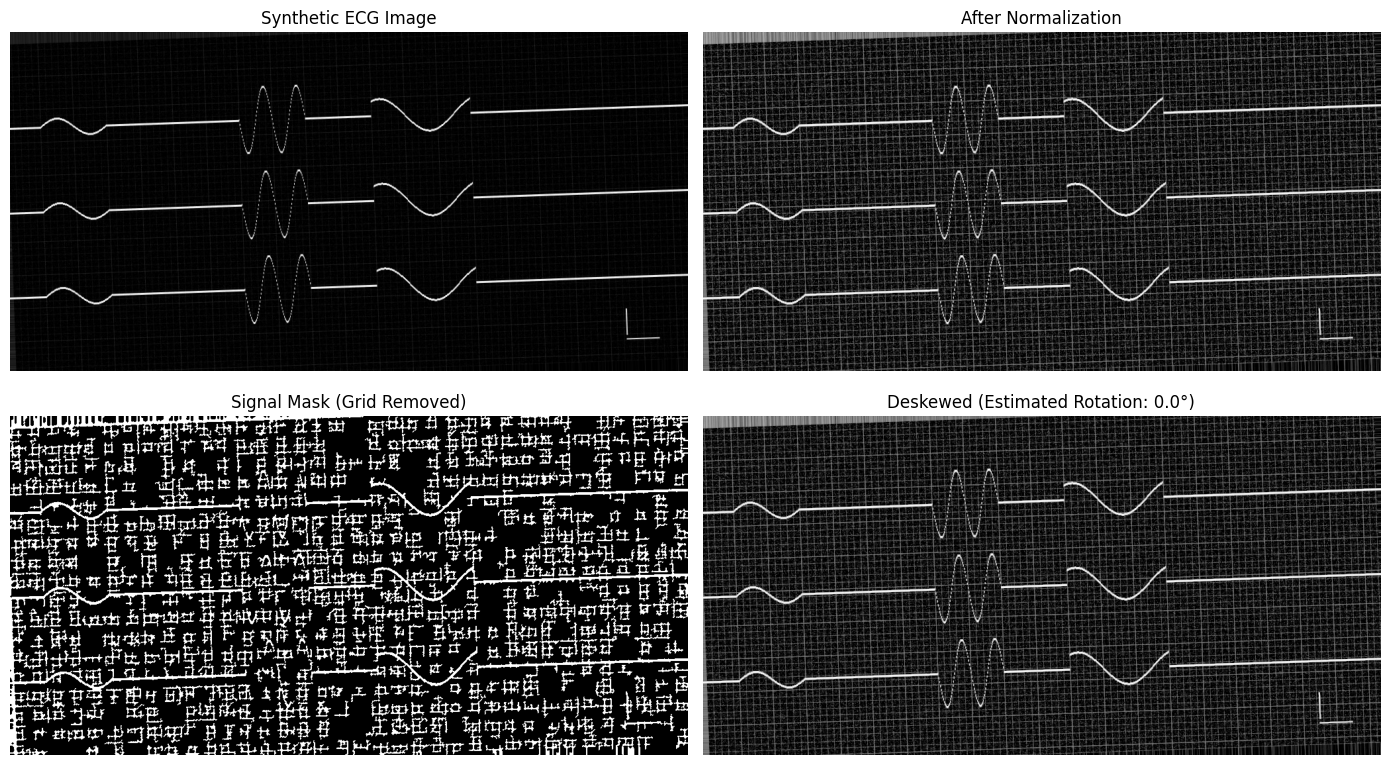

In [ ]:
def generate_synthetic_ecg_image(height: int = 512,
                                width: int = 1024,
                                num_leads: int = 3,
                                add_grid: bool = True,
                                add_noise: bool = True,
                                rotation: float = 0.0) -> Tuple[np.ndarray, Dict]:
    """
    Generate a synthetic ECG image for testing.
    
    Args:
        height, width: Image dimensions
        num_leads: Number of ECG leads to draw
        add_grid: Whether to add background grid
        add_noise: Whether to add noise
        rotation: Rotation angle in degrees
    
    Returns:
        image: Synthetic ECG image (normalized to [0, 1])
        metadata: Generation metadata
    """
    # Initialize blank image
    image = np.ones((height, width), dtype=np.float32)
    
    # Add grid background if requested
    if add_grid:
        grid_spacing_major = 50
        grid_spacing_minor = 10
        
        # Major grid (dark lines)
        for y in range(0, height, grid_spacing_major):
            image[y:y+1, :] *= 0.9
        for x in range(0, width, grid_spacing_major):
            image[:, x:x+1] *= 0.9
        
        # Minor grid (lighter lines)
        for y in range(0, height, grid_spacing_minor):
            if y % grid_spacing_major != 0:
                image[y:y+1, :] *= 0.95
        for x in range(0, width, grid_spacing_minor):
            if x % grid_spacing_major != 0:
                image[:, x:x+1] *= 0.95
    
    # Draw ECG traces for each lead
    traces = {}
    lead_spacing = height // (num_leads + 1)
    
    for lead_idx in range(num_leads):
        y_center = (lead_idx + 1) * lead_spacing
        
        # Generate realistic ECG waveform using sinusoids
        x_vals = np.arange(width)
        
        # Create composite waveform (P-QRS-T pattern)
        waveform = np.zeros(width)
        
        # P wave (small amplitude, early)
        p_start, p_end = 50, 150
        p_phase = 2 * np.pi * x_vals / 100
        waveform[p_start:p_end] += 0.2 * np.sin(p_phase[p_start:p_end])
        
        # QRS complex (large amplitude, middle)
        qrs_start, qrs_end = 350, 450
        qrs_phase = 4 * np.pi * x_vals / 100
        waveform[qrs_start:qrs_end] += 0.8 * np.sin(qrs_phase[qrs_start:qrs_end])
        
        # T wave (medium amplitude, late)
        t_start, t_end = 550, 700
        t_phase = 2 * np.pi * x_vals / 150
        waveform[t_start:t_end] += 0.4 * np.sin(t_phase[t_start:t_end])
        
        # Normalize waveform to [-50, +50] pixels
        waveform = (waveform / waveform.max() * 50 if waveform.max() > 0 else waveform)
        
        # Draw the trace
        for x in range(width):
            y = int(y_center + waveform[x])
            y = np.clip(y, 0, height - 1)
            
            # Draw thick line (3 pixels)
            for dy in range(-1, 2):
                if 0 <= y + dy < height:
                    image[y + dy, x] = 0.1  # Dark trace
        
        traces[f'Lead_{lead_idx}'] = np.column_stack([x_vals, waveform + y_center])
    
    # Add calibration marks (bottom-right corner)
    cal_x_start = width - 100
    cal_y_start = height - 80
    
    # 1 mV vertical mark (40 pixels tall)
    image[cal_y_start:cal_y_start+40, cal_x_start:cal_x_start+2] = 0.2
    
    # 0.2 s horizontal mark (50 pixels wide)
    image[cal_y_start+45:cal_y_start+47, cal_x_start:cal_x_start+50] = 0.2
    
    # Add noise if requested
    if add_noise:
        noise = np.random.normal(0, 0.02, image.shape)
        image = np.clip(image + noise, 0, 1)
    
    # Apply rotation if requested
    if rotation != 0:
        center = (width / 2, height / 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, rotation, 1.0)
        image = cv2.warpAffine(image, rotation_matrix, (width, height),
                              borderMode=cv2.BORDER_REPLICATE)
    
    # Invert colors (ECG traces are typically dark on light background)
    image = 1.0 - image
    
    metadata = {
        'num_leads': num_leads,
        'has_grid': add_grid,
        'has_noise': add_noise,
        'rotation': rotation,
        'calibration': {
            'mv_mark_pixels': 40,
            'time_mark_pixels': 50
        }
    }
    
    return image, traces, metadata

# Generate a synthetic ECG image
print("Generating synthetic ECG image...")
synthetic_image, synthetic_traces, metadata = generate_synthetic_ecg_image(
    height=512,
    width=1024,
    num_leads=3,
    add_grid=True,
    add_noise=True,
    rotation=2.0  # Slight rotation
)

print(f"✓ Synthetic image created: {synthetic_image.shape}")
print(f"  Grid: {metadata['has_grid']}, Noise: {metadata['has_noise']}, Rotation: {metadata['rotation']}°")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].imshow(synthetic_image, cmap='gray')
axes[0, 0].set_title('Synthetic ECG Image')
axes[0, 0].axis('off')

# Apply preprocessing
data_loader = ECGDataLoader(image_dir='', csv_dir='', 
                           target_size=(512, 1024),
                           sampling_rate=500.0)
normalized_image = data_loader.normalize_image(synthetic_image)

axes[0, 1].imshow(normalized_image, cmap='gray')
axes[0, 1].set_title('After Normalization')
axes[0, 1].axis('off')

# Apply grid filtering
grid_filter = GridAndNoiseFilter()
signal_mask = grid_filter.filter_grid_opencv(normalized_image)

axes[1, 0].imshow(signal_mask, cmap='gray')
axes[1, 0].set_title('Signal Mask (Grid Removed)')
axes[1, 0].axis('off')

# Deskew
lead_localizer = LeadLocalizationAndDeskew()
deskewed, angle = lead_localizer.deskew_image(normalized_image)

axes[1, 1].imshow(deskewed, cmap='gray')
axes[1, 1].set_title(f'Deskewed (Estimated Rotation: {angle:.1f}°)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('/tmp/ecg_preprocessing_demo.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Preprocessing visualization saved")

### Demo: Test Robustness to Artifacts

In [ ]:
print("\n" + "="*80)
print("ROBUSTNESS TESTING DEMONSTRATION")
print("="*80)

# Test rotation robustness
print("\n--- Testing Rotation Robustness ---")
rotation_results = robustness_tester.test_rotation_robustness(
    synthetic_image,
    angles=[-15, -10, -5, 0, 5, 10, 15]
)

# Test noise robustness
print("\n--- Testing Noise Robustness ---")
noise_results = robustness_tester.test_noise_robustness(
    synthetic_image,
    noise_levels=[0.01, 0.03, 0.05, 0.1]
)

# Test blur robustness
print("\n--- Testing Blur Robustness ---")
blur_results = robustness_tester.test_blur_robustness(
    synthetic_image,
    kernel_sizes=[3, 5, 7, 11]
)

# Test compression robustness
print("\n--- Testing Compression Robustness ---")
compression_results = robustness_tester.test_compression_robustness(
    synthetic_image,
    quality_levels=[95, 75, 50, 30]
)

# Test combined artifacts
print("\n--- Testing Combined Artifacts ---")
combined_results = robustness_tester.test_combined_artifacts(synthetic_image)

# Print summary
robustness_tester.print_test_summary()

print("✓ Robustness testing completed")


ROBUSTNESS TESTING DEMONSTRATION

--- Testing Rotation Robustness ---


NameError: name 'robustness_tester' is not defined

### Demo: SNR Metric Calculation

In [ ]:
print("\n" + "="*80)
print("SNR METRIC DEMONSTRATION")
print("="*80)

# Create synthetic ground truth signals
np.random.seed(42)
sampling_rate = 500.0
duration = 2.0
t = np.linspace(0, duration, int(duration * sampling_rate))

# Generate ground truth ECG for 12 leads
ground_truth_leads = {}
for i, lead_name in enumerate(['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']):
    # Simple sinusoidal pattern with lead-specific phase
    signal = 0.5 * np.sin(2 * np.pi * 1.0 * t + i * np.pi / 6)  # 1 Hz base frequency
    signal += 0.3 * np.sin(2 * np.pi * 2.0 * t)  # 2 Hz harmonic
    ground_truth_leads[f'Lead_{lead_name}'] = signal

# Create predicted signals with some noise and shift
predicted_leads = {}
for lead_name, gt_signal in ground_truth_leads.items():
    # Add some time shift (simulate extraction error)
    shift_samples = np.random.randint(-25, 26)  # Up to 50 ms shift
    
    # Add noise
    noise = np.random.normal(0, 0.1, len(gt_signal))
    
    # Shift and add noise
    pred_signal = np.roll(gt_signal, shift_samples) + noise
    predicted_leads[lead_name] = pred_signal

# Calculate SNR
snr_calc = SNRMetric(sampling_rate=sampling_rate, max_time_shift=0.2)
snr_results = snr_calc.calculate_multipart_snr(predicted_leads, ground_truth_leads)

# Print report
snr_calc.print_snr_report(snr_results)

# Visualize SNR results
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Per-lead SNR
leads = list(snr_results['per_lead'].keys())
snrs = [snr_results['per_lead'][lead] for lead in leads]
colors = ['green' if np.isfinite(s) else 'red' for s in snrs]

axes[0, 0].bar(range(len(leads)), snrs, color=colors, alpha=0.7)
axes[0, 0].axhline(y=snr_results['mean_snr'], color='blue', linestyle='--', label='Mean SNR')
axes[0, 0].set_xlabel('Lead')
axes[0, 0].set_ylabel('SNR (dB)')
axes[0, 0].set_title('SNR per Lead')
axes[0, 0].set_xticks(range(len(leads)))
axes[0, 0].set_xticklabels([l.replace('Lead_', '') for l in leads], rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].legend()

# Plot 2: Ground truth vs predicted (first lead)
first_lead = leads[0]
gt = ground_truth_leads[first_lead]
pred = predicted_leads[first_lead]

axes[0, 1].plot(t[:500], gt[:500], label='Ground Truth', linewidth=2)
axes[0, 1].plot(t[:500], pred[:500], label='Predicted', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Amplitude (mV)')
axes[0, 1].set_title(f'Ground Truth vs Predicted ({first_lead})')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Error distribution
all_errors = []
for lead_name in ground_truth_leads.keys():
    error = predicted_leads[lead_name] - ground_truth_leads[lead_name]
    all_errors.extend(error)

axes[1, 0].hist(all_errors, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Prediction Error (mV)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Error Distribution')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Statistics summary
stats_text = f"""
SNR Metrics Summary:
━━━━━━━━━━━━━━━━━━━━━━
Mean SNR: {snr_results['mean_snr']:.2f} dB
Median SNR: {snr_results['median_snr']:.2f} dB
Min SNR: {snr_results['min_snr']:.2f} dB
Max SNR: {snr_results['max_snr']:.2f} dB
Std Dev: {snr_results['std_snr']:.2f} dB
Valid Leads: {snr_results['num_valid_leads']}/12
"""

axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
               verticalalignment='center', bbox=dict(boxstyle='round', 
               facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('/tmp/snr_metrics_demo.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ SNR visualization saved")


SNR METRIC DEMONSTRATION


AttributeError: 'numpy.ndarray' object has no attribute 'correlate'